In [ ]:
# Download Miniconda installer (Linux, 64-bit)
!wget https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
# Run the installer
!bash Miniconda3-latest-Linux-x86_64.sh
# Restart shell or source .bashrc to enable conda
!source ~/.bashrc
# Test conda
!conda --version


In [ ]:
!git clone https://github.com/LLaVA-VL/LLaVA-NeXT


In [ ]:
!conda create -n llava python=3.10 -y
!conda activate llava
%pip install --upgrade pip
%pip install -e ".[train]"

In [6]:
import huggingface_hub
import os

print("HuggingFace cache dir (env):", os.getenv("HF_HOME"))
print("huggingface_hub cache dir:", huggingface_hub.constants.HF_HUB_CACHE)

HuggingFace cache dir (env): /storage/yushan13/hf_cache
huggingface_hub cache dir: /storage/yushan13/hf_cache


In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print("Device:", device)

Device: cuda


In [11]:
import torch
torch.cuda.empty_cache()
torch.cuda.reset_peak_memory_stats()


## Reproduction

### Model loading

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

pretrained = "lmms-lab/llama3-llava-next-8b"
model_name = "llava_llama3"
device = "cpu"
device_map = "auto"
llava_next_tokenizer, llava_next_model, llava_next_image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map, attn_implementation=None)

llava_next_model.eval()
llava_next_model.tie_weights()

In [ ]:
url = "https://github.com/haotian-liu/LLaVA/blob/1a91fc274d7c35a9b50b3cb29c4247ae5837ce39/images/llava_v1_5_radar.jpg?raw=true"
image = Image.open(requests.get(url, stream=True).raw)
image_tensor = process_images([image], llava_next_image_processor, llava_next_model.config)
image_tensor = [_image.to(dtype=torch.float16, device=device) for _image in image_tensor]

conv_template = "llava_llama_3"
question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.tokenizer = llava_next_tokenizer # adding thie line to avoid the error: ValueError: Llama 3 tokenizer is not available. Make sure you have the necessary permissions.
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, llava_next_tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]


cont = llava_next_model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=256,
)
text_outputs = llava_next_tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs)

## Dataset Conversion

In [2]:
import json
from PIL import Image

# Load dataset
# with open("/storage/yushan13/LLaVA-Med/data/instruct/llava_med_instruct_10k.json", "r") as f:
    # dataset = json.load(f)
dataset = []
with open("/storage/yushan13/LLaVA-Med/data/eval/llava_med_eval_qa50_qa.jsonl", "r", encoding="utf-8") as f:
    for line in f:
        item = json.loads(line)
        dataset.append(item)

test dataset image missing, using instruct data, split into train(200) & test(100)

In [ ]:
import json
from PIL import Image

# Load dataset
# with open("/storage/yushan13/LLaVA-Med/data/instruct/llava_med_instruct_10k.json", "r") as f:
    # dataset = json.load(f)
instruct_dataset = []
with open("/storage/yushan13/LLaVA-Med/data/instruct/llava_med_instruct_10k.json", "r", encoding="utf-8") as f:
    instruct_dataset = json.load(f)


9888


In [4]:
import random
print(len(instruct_dataset))

total_indices = list(range(len(instruct_dataset)))
train_indices = random.sample(total_indices, 200)
remaining_indices = [i for i in total_indices if i not in train_indices]
test_indices = random.sample(remaining_indices, 100)

# Extract subsets
train_data = [instruct_dataset[i] for i in train_indices]
test_data = [instruct_dataset[i] for i in test_indices]
with open("/storage/yushan13/train.json", "w") as f:
    json.dump(train_data, f, indent=2)
with open("/storage/yushan13/test.json", "w") as f:
    json.dump(test_data, f, indent=2)

9888


In [ ]:
import json

target_pair_ids = {item["id"] for item in train_data if "id" in item}
# target_pair_ids = {item["pair_id"] for item in test_data if "pair_id" in item}
# print(f"Target IDs: {target_pair_ids}")

input_file = "/storage/yushan13/LLaVA-Med/data/llava_med_image_urls.jsonl"
output_file = "/storage/yushan13/dataset/filtered_data.jsonl"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        data = json.loads(line)
        if data.get("pair_id") in target_pair_ids:  # Check if pair_id matches
            outfile.write(line)  # Write the entire original line (preserves formatting)
            print(f"Matched pair_id: {data.get('pair_id')} with image: {data.get('image')}")

print(f"Filtered data saved to {output_file}")

In [ ]:
target_pair_ids = {item["id"] for item in test_data if "id" in item}
print(f"Target IDs: {target_pair_ids}")

input_file = "/storage/yushan13/LLaVA-Med/data/llava_med_image_urls.jsonl"
output_file = "/storage/yushan13/dataset/filtered_data_test.jsonl"

with open(input_file, "r") as infile, open(output_file, "w") as outfile:
    for line in infile:
        data = json.loads(line)
        if data.get("pair_id") in target_pair_ids:  # Check if pair_id matches
            outfile.write(line)  # Write the entire original line (preserves formatting)
            print(f"Matched pair_id: {data.get('pair_id')} with image: {data.get('image')}")

print(f"Filtered data saved to {output_file}")

### QWEN

In [11]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

import sys
import warnings

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/homes/iws/yushan13/.local/l

In [ ]:
pretrained = "lmms-lab/llava-onevision-qwen2-0.5b-si"
model_name = "llava_qwen"
device = "cuda"
device_map = "auto"
tokenizer, model, image_processor, max_length = load_pretrained_model(pretrained, None, model_name, device_map=device_map, attn_implementation=None)
conv_template = "qwen_1_5"

In [ ]:

question = DEFAULT_IMAGE_TOKEN + "\nWhat is shown in this image?"
conv = copy.deepcopy(conv_templates[conv_template])
conv.append_message(conv.roles[0], question)
conv.append_message(conv.roles[1], None)
prompt_question = conv.get_prompt()

input_ids = tokenizer_image_token(prompt_question, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt").unsqueeze(0).to(device)
image_sizes = [image.size]


cont = model.generate(
    input_ids,
    images=image_tensor,
    image_sizes=image_sizes,
    do_sample=False,
    temperature=0,
    max_new_tokens=4096,
)
text_outputs = tokenizer.batch_decode(cont, skip_special_tokens=True)
print(text_outputs)

### Deepseek ai

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "deepseek-ai/deepseek-llm-7b-base"  # or the medical fine-tuned variant if available
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,  # Use float16 for faster inference (if GPU available)
    device_map="auto",  # Automatically loads on GPU if available
)

# Optional: Quantization for lower memory usage (if using consumer GPU)
# model = AutoModelForCausalLM.from_pretrained(model_name, load_in_4bit=True)

In [44]:
print(model)
print(model.device)

LlamaForCausalLM(
  (model): LlamaModel(
    (embed_tokens): Embedding(102400, 4096)
    (layers): ModuleList(
      (0-29): 30 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (v_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (up_proj): Linear(in_features=4096, out_features=11008, bias=False)
          (down_proj): Linear(in_features=11008, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
  )
  (lm_head)

generating takes too long... try inference_mode

In [3]:
import json

# Load the caption file
with open("/storage/yushan13/LLaVA-Med/data/instruct/llava_med_instruct_fig_captions.json") as f:
    caption_data = json.load(f)

# Create a lookup dictionary {pair_id: caption}
caption_lookup = {}
for domain in caption_data:  # e.g., "chest_xray", "mri", etc.
    for item in caption_data[domain]:
        caption_lookup[item["pair_id"]] = item["fig_caption"]

print(f"Loaded {len(caption_lookup)} captions")

Loaded 144984 captions


In [45]:
def build_prompt(caption: str, question: str, original_answer: str) -> str:
    return f"""
    ### Task:
    As a medical expert, rewrite the answer to include clinical reasoning while staying concise.

    ### Image Context:
    {caption}

    ### Question:
    {question}

    ### Original Answer:
    {original_answer}

    ### Guidelines for Enhanced Answer:
    1. Restate the key finding.
    2. Explain the physiological/pathological basis.
    3. Mention relevant anatomical structures.
    4. Include differentials if applicable.
    5. Keep it under 3 sentences unless complex.

    ### Enhanced Answer:
    """

In [46]:
def generate_reasoned_answer(
    caption: str,
    question: str,
    original_answer: str,
    max_new_tokens: int = 200,
) -> str:
    prompt = build_prompt(caption, question, original_answer)
    
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
    
    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.3,  # Lower = more deterministic
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
    )
    
    full_response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    
    # Extract only the new generated part (after "### Enhanced Answer:")
    enhanced_part = full_response.split("### Enhanced Answer:")[1].strip()
    return enhanced_part

### eval data - discard

In [20]:

converted_dataset = []
missed_dataset = []

In [ ]:
print(model.device)
for item in dataset:
    image = item["image"]
    id = item["question_id"]
    caption = item["fig_caption"]
    question = item["text"]
    original_ans = item["gpt4_answer"]
    answer = generate_reasoned_answer(caption, question, original_ans)
    if not answer:
        print(f"No answer found for {id}.")
        missed_dataset.append(id)
        continue
    converted_item = {
        "id": id,
        "image": image,
        "caption": caption,
        "question": question,
        "converted_answer": answer
    }
    if id % 20 == 0:
        print(f"Processed {id} items, last item: {converted_item}")
    converted_dataset.append(converted_item)

In [12]:
print(missed_dataset)
print(len(converted_dataset))

[42, 99]
193


In [11]:
for item in dataset:
    if item["question_id"] in missed_dataset:
        image = item["image"]
        id = item["question_id"]
        caption = item["fig_caption"]
        question = item["text"]
        original_ans = item["gpt4_answer"]
        answer = generate_reasoned_answer(caption, question, original_ans)
        if not answer:
            print(f"No answer found for {id}.")
            missed_dataset.append(id)
            continue
        converted_item = {
            "id": id,
            "image": image,
            "caption": caption,
            "question": question,
            "converted_answer": answer
        }
        converted_dataset.append(converted_item)

In [13]:
output_file = "/storage/yushan13/converted_data_deepseek.json"
# Save to JSON
with open(output_file, "w") as f:
    json.dump(converted_dataset, f, indent=2)

print("Saved with IDs!")

print(f"Saved {len(converted_dataset)} items to {output_file}")

Saved with IDs!
Saved 193 items to /storage/yushan13/converted_data_deepseek.json


### instruct data

In [7]:
with open("/storage/yushan13/dataset/train.json") as f:
    train = json.load(f)
print(len(train))

200


In [ ]:
enhanced_data = []

In [ ]:
for item in train[84:100]:
    pair_id = item["id"]
    caption = caption_lookup.get(pair_id, "No caption available")
    if caption == "No caption available":
        print(f"No caption found for pair_id {pair_id}. Skipping item.")
        continue
    
    qa_pairs = []
    for i in range(len(item["conversatons"])):
        if item["conversatons"][i]["from"] == "human":
            question = item["conversatons"][i]["value"]
            if i+1 < len(item["conversatons"]) and item["conversatons"][i+1]["from"] == "gpt":
                answer = item["conversatons"][i+1]["value"]
                qa_pairs.append((question, answer))
    print(f"Found {len(qa_pairs)} Q&A pairs for pair_id {pair_id}")
        
    for question, answer in qa_pairs:
        reasoned_answer = generate_reasoned_answer(
            caption=caption,
            question=question,
            original_answer=answer
        )
        
        enhanced_data.append({
            "id": item["id"],
            "image": item["image"],
            "caption": caption,  # Same for all QAs of this image
            "question": question,
            "original_answer": answer,
            "reasoned_answer": reasoned_answer
        })
    print(f"Processed item with pair_id {pair_id}, total enhanced items: {len(enhanced_data)}")
    if (len(enhanced_data) % 20 == 0):
        print(f"Processed {len(enhanced_data)} items, last item: {enhanced_data[-1]}")

In [13]:
print(len(enhanced_data))

496


In [14]:
output_file = "/storage/yushan13/dataset/instruct_converted_deepseek.json"
# Save to JSON
with open(output_file, "w") as f:
    json.dump(enhanced_data, f, indent=2)

print("Saved with IDs!")

print(f"Saved {len(enhanced_data)} items to {output_file}")

Saved with IDs!
Saved 496 items to /storage/yushan13/dataset/instruct_converted_deepseek.json


### Convert into LLaVA format

In [35]:
llava_dataset = []
for item in enhanced_data:
    question = item["question"]
    if "<image>" in question:
        question = question.replace("<image>", "").strip()
    question = f"<image>\n{question}"
    llava_item = {
        "id": item["id"], 
        "image": item["image"],
        "conversations": [
            {
                "from": "human",
                "value": question
            },
            {
                "from": "gpt",
                "value": item["reasoned_answer"]
            }
        ]
    }
    llava_dataset.append(llava_item)

# Save to JSON
output_file = "/storage/yushan13/dataset/instruct_converted_deepseek_llava_format.json"
with open(output_file, "w") as f:
    json.dump(llava_dataset, f, indent=2)

## Fine-Tune

In [5]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch
print(device)
pretrained = "lmms-lab/llama3-llava-next-8b"
model_name = "llava_llama3"
device = device
device_map = "auto"
tokenizer, model, image_processor, _ = load_pretrained_model(
    model_path=pretrained,
    model_base=None,
    model_name=model_name,
    device_map="auto", 
    attn_implementation=None
)

cuda
Loaded LLaVA model: lmms-lab/llama3-llava-next-8b


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


Loading vision tower: openai/clip-vit-large-patch14-336


/homes/iws/yushan13/.local/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/homes/iws/yushan13/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the checkpoint to a meta parameter in the current model, which is a no-op. (Did you mean to pass `assign=True` to assign items in the state dictionary to their corresponding key in the module instead of copying them in place?)
  warnings.warn(f'for {key}: copying from a non-meta parameter in the checkpoint to a meta '
/homes/iws/yushan13/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:2025: Us

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Model Class: LlavaLlamaForCausalLM


In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./llava-finetune",
    per_device_train_batch_size=1,
    gradient_accumulation_steps=4,
    learning_rate=2e-5,
    num_train_epochs=20,
    logging_steps=100,
    save_strategy="epoch",
    fp16=True,  # if you're using GPU
    report_to="none",  # Disable reporting to avoid clutter
)

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    pad_to_multiple_of=8,
    padding=True,
    return_tensors="pt"
)

In [ ]:
from torch.utils.data import Dataset
import torch
from pathlib import Path
import os
from PIL import Image

class LLaVADataset(Dataset):
    def __init__(self, data, tokenizer, image_processor, image_root="/storage/yushan13/dataset/data/images"):
        self.data = data
        self.tokenizer = tokenizer
        self.image_processor = image_processor
        self.image_root = Path(image_root)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        item = self.data[idx]
        image_path = os.path.join(self.image_root, item["image"])
        image = Image.open(image_path).convert("RGB")
        image_tensor = process_images([image], self.image_processor, model.config)[0]

         # Process conversations
        input_text = ""
        target_text = ""
        for turn in item["conversations"]:
            text = turn["value"].replace("<image>", DEFAULT_IMAGE_TOKEN)
            if turn["from"] == "human":
                input_text += text + " "
            else:
                target_text += text + " "
        
        # Tokenize with padding
        inputs = tokenizer(
            input_text.strip(),
            padding="max_length",
            max_length=512,
            truncation=True,
            return_tensors="pt"
        )
        
        labels = tokenizer(
            target_text.strip(),
            padding="max_length",
            max_length=512,
            truncation=True,
            return_tensors="pt"
        ).input_ids

        return {
            "input_ids": inputs.input_ids.squeeze(0),
            "attention_mask": inputs.attention_mask.squeeze(0),
            "labels": labels.squeeze(0),
            "pixel_values": image_tensor
        }

In [ ]:
import json
with open("/storage/yushan13/dataset/instruct_converted_deepseek_llava_format.json", "r") as f:
    llava_data = json.load(f)

print(f"Loaded {len(llava_data)} samples")
llava_data_partial = llava_data[:20]  # Use a smaller subset for initial testing

Loaded 496 samples


In [ ]:
from transformers import Trainer
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token
print(f"Pad token: {tokenizer.pad_token} (ID: {tokenizer.pad_token_id})")

train_dataset = LLaVADataset(llava_data, tokenizer, image_processor)

trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=None,  # optional
)

# Start training
trainer.train()

In [ ]:
model = model.merge_and_unload()
model.save_pretrained("/storage/yushan13/llava-lora-finetuned_full")
tokenizer.save_pretrained("/storage/yushan13/llava-lora-finetuned_full")

('/storage/yushan13/llava-lora-finetuned/tokenizer_config.json',
 '/storage/yushan13/llava-lora-finetuned/special_tokens_map.json',
 '/storage/yushan13/llava-lora-finetuned/tokenizer.json')

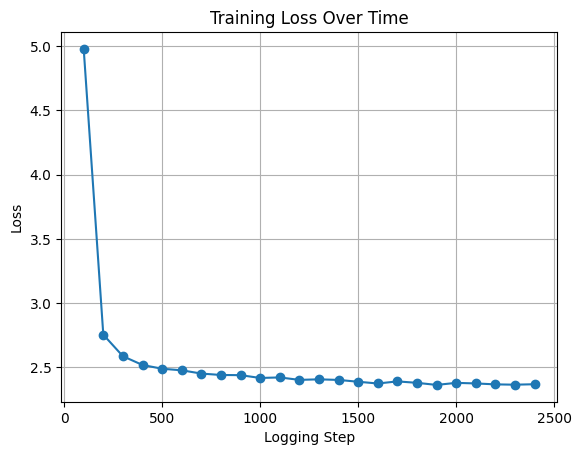

In [42]:
import matplotlib.pyplot as plt

trainer_state_path = "/storage/yushan13/llava-finetune/checkpoint-2480/trainer_state.json"

with open(trainer_state_path, "r") as f:
    trainer_state = json.load(f)

# Extract losses
loss_values = [log["loss"] for log in trainer_state["log_history"] if "loss" in log]
steps = [log["step"] for log in trainer_state["log_history"] if "step" in log]

# Plot
plt.plot(steps, loss_values, marker='o')
plt.title("Training Loss Over Time")
plt.xlabel("Logging Step")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

## Evaluation

### test dataset

In [3]:
import json
with open("/storage/yushan13/dataset/test.json") as f:
    test = json.load(f)
print(len(test))
test_caption = []

99


In [ ]:
for item in test:
    pair_id = item["id"]
    caption = caption_lookup.get(pair_id, "No caption available")
    if caption == "No caption available":
        print(f"No caption found for pair_id {pair_id}. Skipping item.")
        continue
    qa_pairs = []
    for i in range(len(item["conversatons"])):
        if item["conversatons"][i]["from"] == "human":
            question = item["conversatons"][i]["value"]
            if i+1 < len(item["conversatons"]) and item["conversatons"][i+1]["from"] == "gpt":
                answer = item["conversatons"][i+1]["value"]
                qa_pairs.append((question, answer))
    print(f"Found {len(qa_pairs)} Q&A pairs for pair_id {pair_id}")
        
    for question, answer in qa_pairs:
        test_caption.append({
            "id": item["id"],
            "image": item["image"],
            "caption": caption,
            "question": question,
            "original_answer": answer,
        })

In [53]:
output_file = "/storage/yushan13/dataset/qva_eval_with_caption.json"
# Save to JSON
with open(output_file, "w") as f:
    json.dump(test_caption, f, indent=2)

print("Saved with IDs!")

print(f"Saved {len(test_caption)} items to {output_file}")

Saved with IDs!
Saved 516 items to /storage/yushan13/dataset/qva_eval_with_caption.json


### Store fine tuned model

In [ ]:
from llava.model.builder import load_pretrained_model
from peft import PeftModel

# Load PEFT config
# peft_config = PeftConfig.from_pretrained("/storage/yushan13/llava-lora-finetuned")

# Load base model
pretrained = "lmms-lab/llama3-llava-next-8b"
model_name = "llava_llama3"
tokenizer, model, image_processor, _ = load_pretrained_model(
    model_path=pretrained,
    model_base=None,
    model_name=model_name,
    device_map="auto",
    attn_implementation=None
)

# Load LoRA adapters
finetuned_model = PeftModel.from_pretrained(model, "/storage/yushan13/llava-lora-finetuned")
finetuned_model = finetuned_model.merge_and_unload()

In [4]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(finetuned_model)


Using device: cuda
LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(128257, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): L

In [5]:
print(model)

LlavaLlamaForCausalLM(
  (model): LlavaLlamaModel(
    (embed_tokens): Embedding(128257, 4096)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaSdpaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm()
        (post_attention_layernorm): LlamaRMSNorm()
      )
    )
    (norm): LlamaRMSNorm()
    (

In [6]:
finetuned_model.save_pretrained("/storage/yushan13/llava-lora-finetuned_full")
tokenizer.save_pretrained("/storage/yushan13/llava-lora-finetuned_full")

('/storage/yushan13/llava-lora-finetuned_full/tokenizer_config.json',
 '/storage/yushan13/llava-lora-finetuned_full/special_tokens_map.json',
 '/storage/yushan13/llava-lora-finetuned_full/tokenizer.json')

### inference

In [1]:
!PYTHONPATH=. python /storage/yushan13/LLaVA-Med/llava/eval/model_vqa.py \
    --conv-mode llava_llama_3 \
    --model-path lmms-lab/llama3-llava-next-8b \
    --question-file /storage/yushan13/dataset/eval/llava_med_eval_qa50_qa.jsonl \
    --image-folder /storage/yushan13/dataset/data/images \
    --answers-file /storage/yushan13/results/llava_base_model_results.jsonl \
    --temperature 0.0

/homes/iws/yushan13/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loaded LLaVA model: lmms-lab/llama3-llava-next-8b
Loading vision tower: openai/clip-vit-large-patch14-336
/homes/iws/yushan13/.local/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/homes/iws/yushan13/.local/lib/python3.9/site-packages/torch/nn/modules/module.py:2025: UserWarning: for vision_model.embeddings.class_embedding: copying from a non-meta parameter in the ch

### baseline - llava next

In [ ]:
from llava.model.builder import load_pretrained_model
from peft import PeftModel

# Load base model (same as original pretrained)
pretrained = "lmms-lab/llama3-llava-next-8b"
model_name = "llava_llama3"
base_tokenizer, base_model, base_image_processor, _ = load_pretrained_model(
    model_path=pretrained,
    model_base=None,
    model_name=model_name,
    device_map="auto", 
    attn_implementation=None
)



In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import shortuuid

image_base_path = "/storage/yushan13/dataset/data/images"
answers_file = "/storage/yushan13/results/llava_base_model_results.jsonl"
os.makedirs(os.path.dirname(answers_file), exist_ok=True)
# item = test_data[0]
questions = [json.loads(q) for q in open(os.path.expanduser(args.question_file), "r")]
questions = get_chunk(questions, args.num_chunks, args.chunk_idx)
answers_file = os.path.expanduser(args.answers_file)
os.makedirs(os.path.dirname(answers_file), exist_ok=True)
ans_file = open(answers_file, "w")
for line in tqdm(questions):
    idx = line["question_id"]
    image_file = line["image"]
    qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()
    cur_prompt = qs
    if model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    conv = conv_templates[args.conv_mode].copy()
    conv.tokenizer = tokenizer
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    image = Image.open(os.path.join(args.image_folder, image_file))
    image_tensor = process_images([image], image_processor, model.config)[0]
    image_tensor = [_image.to(dtype=torch.float16, device="cuda") for _image in image_tensor]

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            # images=image_tensor.unsqueeze(0).half().cuda(),
            images=image_tensor,
            do_sample=True if args.temperature > 0 else False,
            temperature=args.temperature,
            top_p=args.top_p,
            num_beams=args.num_beams,
            # no_repeat_ngram_size=3,
            max_new_tokens=1024,
            use_cache=True)

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    ans_id = shortuuid.uuid()
    ans_file.write(json.dumps({"question_id": idx,
                                "prompt": cur_prompt,
                                "text": outputs,
                                "answer_id": ans_id,
                                "model_id": model_name,
                                "metadata": {}}) + "\n")
    ans_file.flush()
ans_file.close()

### finetuned model

In [1]:
finetuned_result = []

In [7]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, process_images, tokenizer_image_token
from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN, IGNORE_INDEX
from llava.conversation import conv_templates, SeparatorStyle

from PIL import Image
import requests
import copy
import torch

# model_name = "llava_llama3"
# finetuned_tokenizer, finetuned_model, finetuned_image_processor, context_len = load_pretrained_model(
#     model_path="/storage/yushan13/llava-lora-finetuned_full",
#     model_base=None,
#     model_name=model_name,
#     device_map="auto", 
#     attn_implementation=None
# )

question_file = "/storage/yushan13/dataset/eval/llava_med_eval_qa50_qa.jsonl"
image_folder = "/storage/yushan13/dataset/data/images"
answers_file = "/storage/yushan13/results/llava_finetuned_model_results.jsonl"

/homes/iws/yushan13/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [8]:
import argparse
import torch
import os
import json
from tqdm import tqdm
import shortuuid

from llava.constants import IMAGE_TOKEN_INDEX, DEFAULT_IMAGE_TOKEN, DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import tokenizer_image_token, get_model_name_from_path, KeywordsStoppingCriteria, process_images

from PIL import Image
import math
from transformers import set_seed, logging

logging.set_verbosity_error()


def split_list(lst, n):
    """Split a list into n (roughly) equal-sized chunks"""
    chunk_size = math.ceil(len(lst) / n)  # integer division
    return [lst[i:i+chunk_size] for i in range(0, len(lst), chunk_size)]


def get_chunk(lst, n, k):
    chunks = split_list(lst, n)
    return chunks[k]


# def eval_model(args):
set_seed(0)
# Model
disable_torch_init()
print("loaded model on ", finetuned_model.device)
questions = [json.loads(q) for q in open(os.path.expanduser(question_file), "r")]
questions = get_chunk(questions, 1, 0)
answers_file = os.path.expanduser(answers_file)
os.makedirs(os.path.dirname(answers_file), exist_ok=True)
ans_file = open(answers_file, "w")
for line in tqdm(questions):
    idx = line["question_id"]
    image_file = line["image"]
    qs = line["text"].replace(DEFAULT_IMAGE_TOKEN, '').strip()
    cur_prompt = qs
    if finetuned_model.config.mm_use_im_start_end:
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN + '\n' + qs
    else:
        qs = DEFAULT_IMAGE_TOKEN + '\n' + qs

    conv = conv_templates["llava_llama_3"].copy()
    conv.tokenizer = tokenizer
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    input_ids = tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors='pt').unsqueeze(0).cuda()

    image = Image.open(os.path.join(image_folder, image_file))
    image_sizes = [image.size]
    image_tensor = process_images([image], image_processor, finetuned_model.config)[0]
    # image_tensor = [_image.to(dtype=torch.float16, device="cuda:0") for _image in image_tensor]

    stop_str = conv.sep if conv.sep_style != SeparatorStyle.TWO else conv.sep2
    keywords = [stop_str]
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)

    with torch.inference_mode():
        output_ids = finetuned_model.generate(
            input_ids,
            images=image_tensor.unsqueeze(0).half().cuda(),
            # images=image_tensor,
            image_sizes=image_sizes,
            do_sample=False,
            temperature=0,
            # top_p=args.top_p,
            # num_beams=args.num_beams,
            # no_repeat_ngram_size=3,
            max_new_tokens=1024,
            use_cache=True)

    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()

    ans_id = shortuuid.uuid()
    ans_file.write(json.dumps({"question_id": idx,
                                "prompt": cur_prompt,
                                "text": outputs,
                                "answer_id": ans_id,
                                "model_id": model_name,
                                "metadata": {}}) + "\n")
    ans_file.flush()
ans_file.close()


loaded model on  cuda:0


  0%|          | 0/193 [00:00<?, ?it/s]/homes/iws/yushan13/.local/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:392: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
100%|██████████| 193/193 [38:20<00:00, 11.92s/it]


### score

In [ ]:
INSTRUCT_PROMPT = """We would like to request your feedback on the performance of two AI assistants in response to the user question displayed above. 
  The user asks the question on observing an image. For your reference, the visual content in the image is represented with caption describing the same image.
  Please rate the helpfulness, relevance, accuracy, level of details of their responses. 
  Each assistant receives an overall score on a scale of 1 to 10, where a higher score indicates better overall performance.
  Please first output a single line containing only two values indicating the scores for Assistant 1 and 2, respectively. 
  The two scores are separated by a space. Pleas only include the two scores in the output, without any additional text or explanation."""
ROLE = 'Assistant'

#### base - llava next

** Not runnable - just show the script used **

In [ ]:
def get_domain(x):
  for domain in ['chest_xray', 'mri', 'histology', 'gross', 'ct_scan']:
    in_domain = x['domain'][domain]
    if in_domain:
      return domain
    


def main(args):
    scores_data = util.load_file_jsonl(args.scores_file)
    predictions = [(x['question_id'], x['type'], get_domain(x), x['gpt_eval'].split('\n')[0].split(' ')) for x in scores_data]
    # print(predictions[0])
    
    score_type_dict = defaultdict(lambda: defaultdict(list))
    raw_scores = defaultdict(lambda: defaultdict(list))
    # for q_id, q_type, domain, (a1_score, a2_score) in predictions:
    for q_id, q_type, domain, score_list in predictions:
        a1_score, a2_score = map(int, score_list)
        relative_score = (a2_score / a1_score) * 100 if a1_score != 0 else 0
        score_type_dict[q_type][1].append(a1_score)
        score_type_dict[q_type][2].append(a2_score)
        score_type_dict['overall'][1].append(a1_score)
        score_type_dict['overall'][2].append(a2_score)
        score_type_dict[domain][1].append(a1_score)
        score_type_dict[domain][2].append(a2_score)

        raw_scores[q_type]['gpt4_scores'].append(a1_score)
        raw_scores[q_type]['pred_scores'].append(a2_score)
        raw_scores[domain]['gpt4_scores'].append(a1_score)
        raw_scores[domain]['pred_scores'].append(a2_score)
        raw_scores[q_type]['relative_scores'].append(relative_score)
        raw_scores[domain]['relative_scores'].append(relative_score)


    result = defaultdict(dict)

    for q_type, score_dict in score_type_dict.items():
        result[q_type]['gpt4_score'] = util.get_avg(score_dict[1])
        result[q_type]['pred_score'] = util.get_avg(score_dict[2])
        result[q_type]['pred_relative_score'] = util.get_avg([float(s2)/float(s1) for s1, s2 in zip(score_dict[1], score_dict[2])])*100
        result[q_type]['data_size'] = len(score_dict[1])

    df = pd.DataFrame.from_dict(result).filter(['conversation', 'detailed_description', 'chest_xray', 'mri', 'histology', 'gross', 'ct_scan', 'overall'])
    print(df)
    df.to_csv(args.summarize_file, index=True, float_format='%.2f')
    print(f"Saved CSV results to {args.summarize_file}")

    raw_filename = args.summarize_file.replace('.csv', '_raw_scores.csv')
    raw_data = []
    for category, scores in raw_scores.items():
        for score_type, values in scores.items():
            for value in values:
                raw_data.append({
                    'category': category,
                    'score_type': score_type,
                    'value': value
                })
    
    df_raw = pd.DataFrame(raw_data)
    df_raw.to_csv(raw_filename, index=False)
    print(f"Saved raw scores for histograms to {raw_filename}")
    

if __name__ == '__main__':
   parser = argparse.ArgumentParser("GPT-4 Multimodal Chat Eval Postprocessing", add_help=True)
   parser.add_argument("--scores-file", default="", metavar="FILE", help="input path to gpt-4 score file")
   parser.add_argument("--summarize-file", default="", metavar="FILE", help="input path to gpt-4 score file")
   args = parser.parse_args()
   main(args)

In [1]:
!python /storage/yushan13/LLaVA-Med/llava/eval/eval_multimodal_chat_gpt_score.py \
    --answers-file /storage/yushan13/results/llava_base_model_results.jsonl \
    --question-file /storage/yushan13/LLaVA-Med/data/eval/llava_med_eval_qa50_qa.jsonl \
    --scores-file /storage/yushan13/results/scores_base.jsonl


/homes/iws/yushan13/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████████████| 4/4 [00:05<00:00,  1.40s/it]
/homes/iws/yushan13/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Starting Multimodal Chat GPT Scoring Eval
  0%|                                                   | 0/193 [00:00<?, ?it/s]/homes/iws/yushan13/.local/lib/python3.9/site-packages/transformers/generation/conf

In [30]:
!python /storage/yushan13/LLaVA-Med/llava/eval/summarize_gpt_review.py \
    --scores-file /storage/yushan13/results/scores_base.jsonl \
    --summarize-file /storage/yushan13/results/scores_base_summary.csv 

                     conversation  detailed_description  ...    ct_scan     overall
gpt4_score               8.867133              8.940000  ...   8.850000    8.886010
pred_score               7.104895              6.720000  ...   6.850000    7.005181
pred_relative_score     80.369075             75.183333  ...  77.881944   79.025619
data_size              143.000000             50.000000  ...  40.000000  193.000000

[4 rows x 8 columns]
Saved CSV results to /storage/yushan13/results/scores_base_summary.csv
Saved raw scores for histograms to /storage/yushan13/results/scores_base_summary_raw_scores.csv


#### fine tuned model

In [24]:
!python /storage/yushan13/LLaVA-Med/llava/eval/eval_multimodal_chat_gpt_score.py \
    --answers-file /storage/yushan13/results/llava_finetuned_model_results.jsonl \
    --question-file /storage/yushan13/LLaVA-Med/data/eval/llava_med_eval_qa50_qa.jsonl \
    --scores-file /storage/yushan13/results/scores_finetuned.jsonl


/homes/iws/yushan13/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████████████| 4/4 [00:05<00:00,  1.27s/it]
/homes/iws/yushan13/.local/lib/python3.9/site-packages/huggingface_hub/file_download.py:896: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Starting Multimodal Chat GPT Scoring Eval
  0%|                                                   | 0/193 [00:00<?, ?it/s]/homes/iws/yushan13/.local/lib/python3.9/site-packages/transformers/generation/conf

In [29]:
!python /storage/yushan13/LLaVA-Med/llava/eval/summarize_gpt_review.py \
    --scores-file //storage/yushan13/results/scores_finetuned.jsonl \
    --summarize-file /storage/yushan13/results/scores_finetuned_summary.csv 

                     conversation  detailed_description  ...    ct_scan     overall
gpt4_score               8.832168              8.920000  ...   8.875000    8.854922
pred_score               6.979021              6.760000  ...   6.675000    6.922280
pred_relative_score     79.174437             75.794444  ...  75.041667   78.298791
data_size              143.000000             50.000000  ...  40.000000  193.000000

[4 rows x 8 columns]
Saved CSV results to /storage/yushan13/results/scores_finetuned_summary.csv
Saved raw scores for histograms to /storage/yushan13/results/scores_finetuned_summary_raw_scores.csv


### Visualizations

#### pred vs. ground truth

Ground truth is GPT-generated.
Histogram plot of each model's score compared to GPT score

In [14]:
import pandas as pd

import matplotlib.pyplot as plt

def plot_score_histogram(csv_file, model, bins=10):
    
    df = pd.read_csv(csv_file)
    gpt_scores = df[(df['score_type'] == 'gpt4_scores') &
    (df['category'].isin(['conversation', 'detailed_description']))]['value']
    model_scores = df[(df['score_type'] == 'pred_scores') &
    (df['category'].isin(['conversation', 'detailed_description']))]['value']
    bins = range(1, 12)
    plt.figure(figsize=(8, 5))
    plt.hist(gpt_scores, bins=bins, alpha=0.6, label="GPT-4 (Ground Truth)")
    plt.hist(model_scores, bins=bins, alpha=0.6, label=f"{model}")
    plt.xlabel("Score")
    plt.xticks(range(1, 12))  # Assuming scores are from 0 to 10
    plt.ylabel("Count")
    plt.title(f"Score Distribution: GPT-4 vs. {model}")
    plt.legend()
    plt.grid(True)
    plt.show()

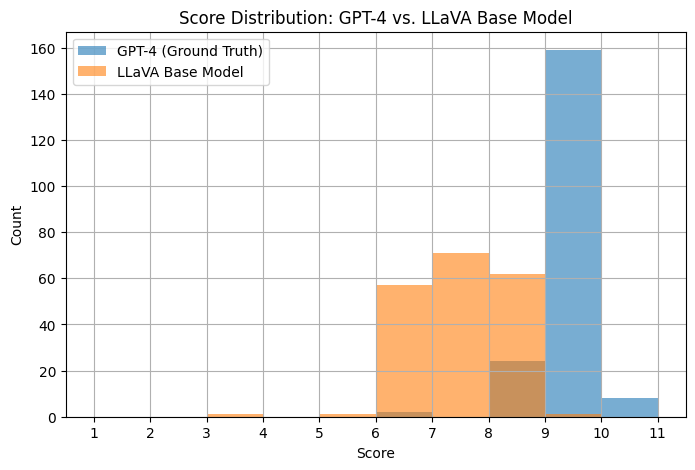

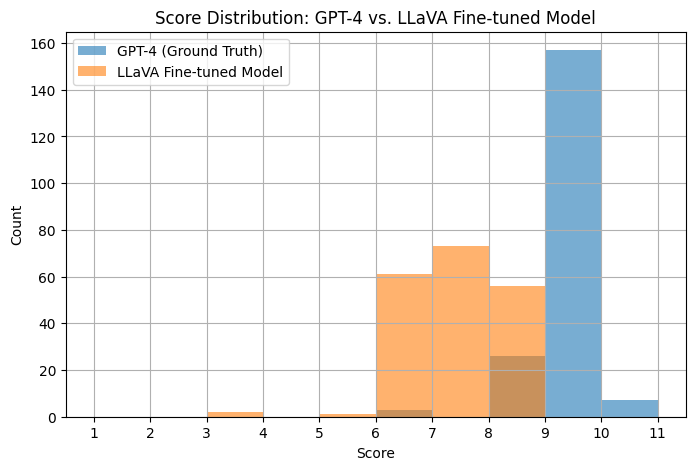

In [15]:
plot_score_histogram("/storage/yushan13/results/scores_base_summary_raw_scores.csv", "LLaVA Base Model")
plot_score_histogram("/storage/yushan13/results/scores_finetuned_summary_raw_scores.csv", "LLaVA Fine-tuned Model")

#### llava next vs. llava next med

Relative pred score of LLaVA NeXT and LLaVA NeXT Med, relative to the ground truth score

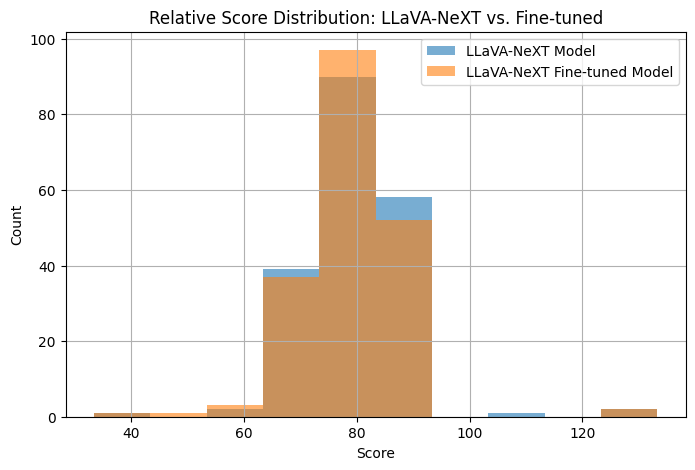

In [50]:
df_base = pd.read_csv("/storage/yushan13/results/scores_base_summary_raw_scores.csv")
df_finetuned = pd.read_csv("/storage/yushan13/results/scores_finetuned_summary_raw_scores.csv")
base_scores = df_base[(df_base['score_type'] == 'relative_scores') &
    (df_base['category'].isin(['conversation', 'detailed_description']))]['value']
finetuned_scores = df_finetuned[(df_finetuned['score_type'] == 'relative_scores') &
    (df_finetuned['category'].isin(['conversation', 'detailed_description']))]['value']

plt.figure(figsize=(8, 5))
plt.hist(base_scores, bins=10, alpha=0.6, label="LLaVA-NeXT Model")
plt.hist(finetuned_scores, bins=10, alpha=0.6, label="LLaVA-NeXT Fine-tuned Model")
plt.xlabel("Score")
plt.ylabel("Count")
plt.title("Relative Score Distribution: LLaVA-NeXT vs. Fine-tuned")
plt.legend()
plt.grid(True)
plt.show()

#### type wise

Relative pred score of each type (decription & conversation)

In [ ]:
import matplotlib.pyplot as plt

def plot_relative_scores_by_type(df_base, df_finetuned, type_name):

    base_type_scores = df_base[(df_base['category'] == type_name) & (df_base['score_type'] == 'relative_scores')]['value']
    finetuned_type_scores = df_finetuned[(df_finetuned['category'] == type_name) & (df_finetuned['score_type'] == 'relative_scores')]['value']

    plt.figure(figsize=(8, 5))
    plt.hist(base_type_scores, bins=10, alpha=0.6, label="LLaVA-NeXT Model")
    plt.hist(finetuned_type_scores, bins=10, alpha=0.6, label="LLaVA-NeXT Fine-tuned Model")
    plt.xlabel("Relative Score")
    plt.ylabel("Count")
    plt.title(f"Relative Score Distribution for '{type_name}'")
    plt.legend()
    plt.grid(True)
    plt.show()

import pandas as pd
import matplotlib.pyplot as plt

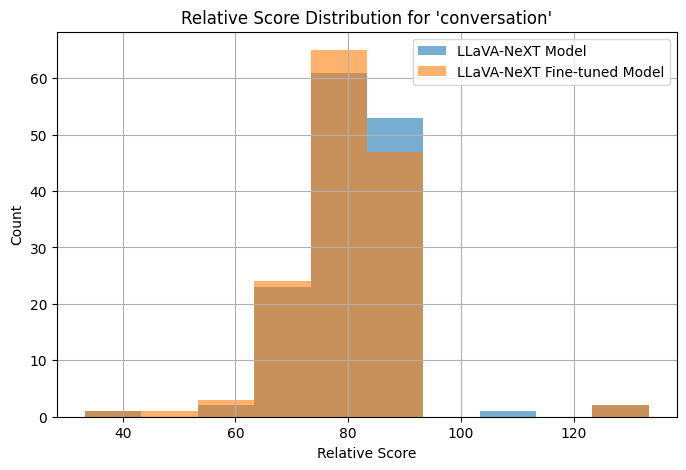

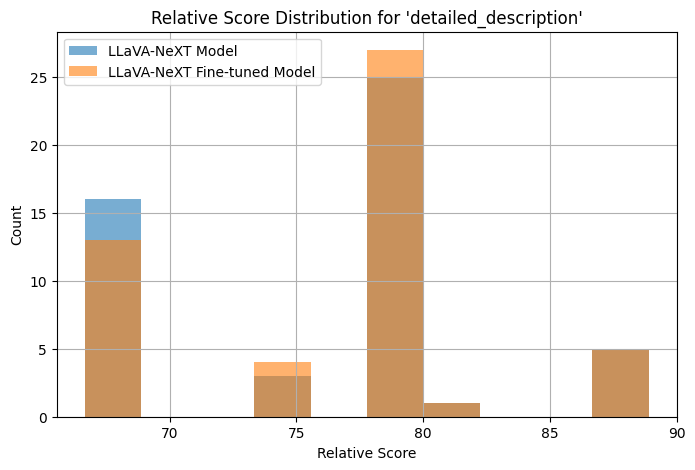

In [47]:
plot_relative_scores_by_type(df_base, df_finetuned, 'conversation')
plot_relative_scores_by_type(df_base, df_finetuned, 'detailed_description')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_average_scores(csv_file_base, csv_file_finetuned, base, finetuned, score_type, categories, type):
    df_base = pd.read_csv(csv_file_base)
    df_finetuned = pd.read_csv(csv_file_finetuned)
    selected_scores_base = df_base.iloc[score_type, categories]
    selected_scores_finetuned = df_finetuned.iloc[score_type, categories]
    # print(selected_scores)
    
    selected_scores_base = selected_scores_base.astype(float)  # Ensure numeric
    selected_scores_finetuned = selected_scores_finetuned.astype(float)  # Ensure numeric
    category_labels = df_base.columns[categories]

    # Setup bar positions
    x = np.arange(len(category_labels)) * 0.6
    width = 0.25  # width of the bars
    fig, ax = plt.subplots(figsize=(8, 6))
    ax.bar(x - width/2, selected_scores_base, width-0.03, label=base, color='skyblue', alpha=0.7)
    ax.bar(x + width/2, selected_scores_finetuned, width-0.03, label=finetuned, color='orange', alpha=0.7)
    for i, v in enumerate(selected_scores_base):
        ax.text(x[i] - width/2, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=9)
    for i, v in enumerate(selected_scores_finetuned):
        ax.text(x[i] + width/2, v + 1, f'{v:.1f}', ha='center', va='bottom', fontsize=9)
    ax.set_xlabel('Categories')
    ax.set_ylabel('Score')
    ax.set_title(f'Comparison of Model Scores by {type}')
    ax.set_ylim(0, 100)
    ax.set_xticks(x)
    ax.set_xticklabels(category_labels, rotation=0, ha='center')
    ax.legend()


    plt.show()

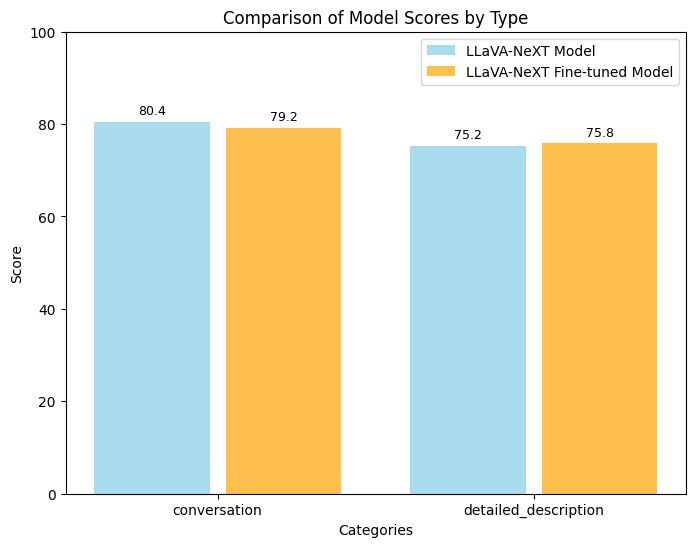

In [3]:
plot_average_scores("/storage/yushan13/results/scores_base_summary.csv", 
                    "/storage/yushan13/results/scores_finetuned_summary.csv",
                    "LLaVA-NeXT Model",
                    "LLaVA-NeXT Fine-tuned Model",
                    score_type=2,
                    categories=[1, 2],
                    type="Type")

#### domain wise

Relative pred score of each domain (chest x-ray; mri; histology; gross; ct-scan)

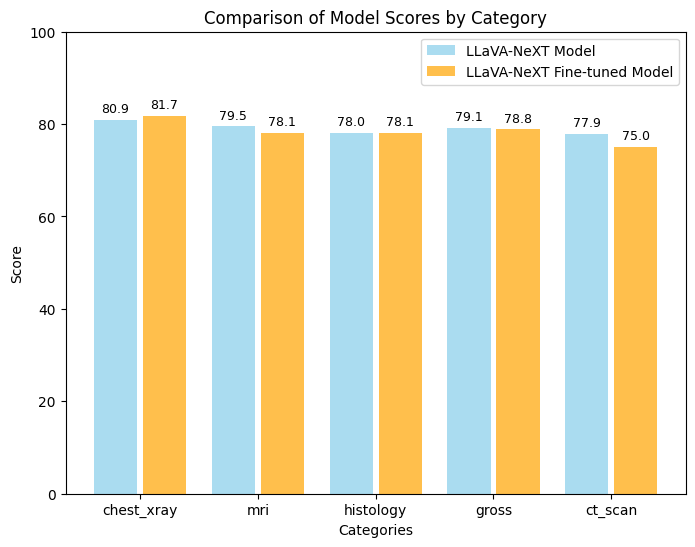

In [4]:
plot_average_scores("/storage/yushan13/results/scores_base_summary.csv", 
                    "/storage/yushan13/results/scores_finetuned_summary.csv",
                    "LLaVA-NeXT Model",
                    "LLaVA-NeXT Fine-tuned Model",
                    score_type=2,
                    categories=[3, 4, 5, 6, 7],
                    type="Category")